In [58]:
PATH = "fedsgd_dense_centralized_v8"

In [59]:
import tensorflow as tf
import sys
import os
sys.path.append("../")

from federated.data.data_preprocessing import load_data
import numpy as np
from matplotlib import pyplot as plt
import itertools
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
import pandas as pd

pd.options.plotting.backend = "plotly"

%matplotlib inline

In [60]:
import nest_asyncio
nest_asyncio.apply()

In [61]:
"""
Function that evaluates the model.
Prints accuracy and loss value
"""
def evaluation(X, y, model):
    scores = model.evaluate(X, y, verbose=0)
    print(f"Accuracy: {scores[1]*100}%, Loss: {scores[0]}")

In [62]:
LABELS = ["N", "S", "V", " F", "U"]

In [63]:
"""
Function that creates confusion matrix based upon the dataset and the model.
Displays the confusion matrix.
"""

def make_confusion_matrix(X,y, model):
    y_pred = model.predict(X)
    y_test = np.argmax(y, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    cnf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(15,15))
    cnf_matrix =  cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Normalized Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(len(LABELS))
    plt.xticks(ticks, LABELS, rotation=45)
    plt.yticks(ticks, LABELS)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j,i,format(cnf_matrix[i,j], '.2f'), horizontalalignment="center",
                    color="white" if cnf_matrix[i, j] > cnf_matrix.max()/2 else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


    plt.show()

    return y_test, y_pred

In [64]:
"""
Function that loads model and dataset for analysis
Returns x_test, y_test and model
"""
def load(name):
    model = tf.keras.models.load_model("../history/logdir/" + name)
    X_test, y_test = load_data(data_analysis=True)

    X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
    # X_test.shape
    evaluation(X_test, y_test, model)
    
    return X_test, y_test, model

In [65]:
def dataframe_from_event(path, type):

    path += f"{type}/"
    event_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    event_files = list(filter(lambda f: "empty" not in f, event_files))
    path += event_files[0]

    metrics = defaultdict(list)
    for e in summary_iterator(path):
        for v in e.summary.value:
            if isinstance(v.simple_value, float) and ("loss" in v.tag or "accuracy" in v.tag):
                metrics[f"{v.tag}_{type}"].append(v.simple_value)
    metrics_df = pd.DataFrame({k: v for k,v in metrics.items() if len(v) > 1})

    return metrics_df

In [66]:
def plot_graph(type):
    
    if type not in ["accuracy", "loss"]:
        raise ValueError(f"type must be accuracy or loss, not {type}")

    path = f"../history/logdir/{PATH}/"
    train_df = dataframe_from_event(path, "train")
    validation_df = dataframe_from_event(path, "validation")

    return pd.concat([train_df, validation_df], axis=1)[[f"epoch_{type}_train", f"epoch_{type}_validation"]]

In [67]:
X_test, y_test, model_centralized = load(PATH)

Accuracy: 32.44564235210419%, Loss: 1.5311636924743652


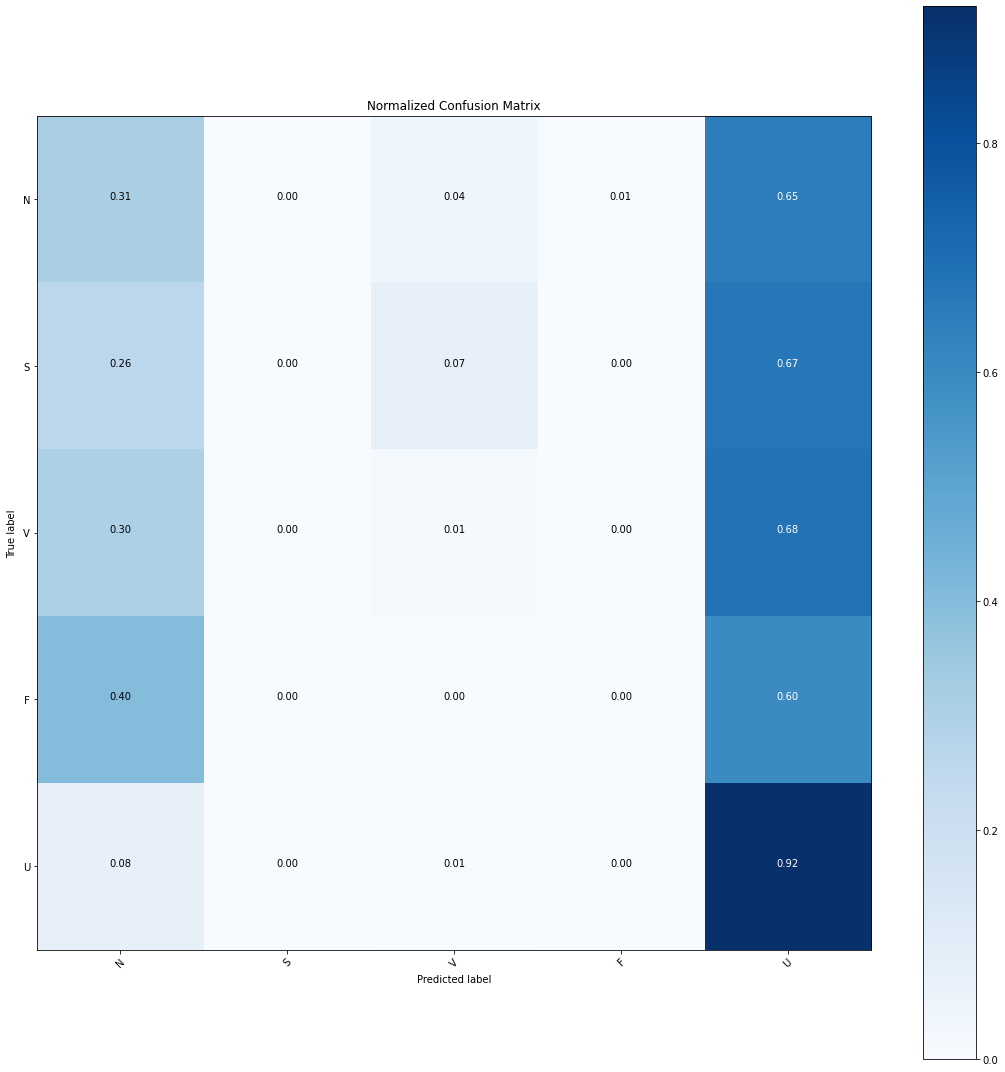

In [68]:
y_test, y_pred = make_confusion_matrix(X_test, y_test, model_centralized)

In [69]:
print(classification_report(y_test, y_pred, target_names=LABELS))

              precision    recall  f1-score   support

           N       0.88      0.31      0.46     18118
           S       0.00      0.00      0.00       556
           V       0.02      0.01      0.02      1448
           F       0.00      0.00      0.00       162
           U       0.10      0.92      0.18      1608

    accuracy                           0.32     21892
   macro avg       0.20      0.25      0.13     21892
weighted avg       0.74      0.32      0.39     21892



In [70]:
metrics_df = plot_graph("accuracy")
metrics_df.plot(title="Epoch Accuracy", labels=dict(index="epochs", value="accuracy", variable="option"))

KeyError: "None of [Index(['epoch_accuracy_train', 'epoch_accuracy_validation'], dtype='object')] are in the [columns]"

In [56]:
metrics_df = plot_graph("loss")
metrics_df.plot(title="Epoch Loss", labels=dict(index="epochs", value="loss", variable="option"))